# Add Trasform Parts

In [2]:
import sys
sys.path.append('../../../../')
import sem_analysis as sa


Loading the model...
Processing input...


In [3]:
import pickle
with open('table.pickle', 'rb') as f:
    table = pickle.load(f)

In [5]:
import string
import time
def get_words(act):
    ret = dict()
    for i in act[0]:
        if i != 'VERB' and i != 'punct':
            ret[i] = list()
            for j in act[0][i]:
                ret[i].append(sa.tag_ud(j))
        elif i == 'VERB':
            ret[i] = sa.tag_ud(act[0][i])
    return ret
actions_transform = dict()
n = 0
t = time.time()
for i in table:
    actions_transform[i] = list()
    for j in table[i]:
        n += 1
        actions_transform[i].append((j[0], get_words(j[0]), j[1]))
        if n % 100 == 0:
            print('%d actions were processed\n%f s \n'%(n, time.time() - t))

100 actions were processed
1243.953515 s 

200 actions were processed
2366.778275 s 

300 actions were processed
3572.625390 s 

400 actions were processed
4793.428817 s 

500 actions were processed
5837.379201 s 

600 actions were processed
6870.482220 s 

700 actions were processed
7889.476156 s 

800 actions were processed
8881.124645 s 

900 actions were processed
9976.425435 s 

1000 actions were processed
10950.233502 s 



In [7]:
with open('data_actions.pickle', 'wb') as f:
    pickle.dump(actions_transform, f)

# Get Attributes

In [26]:
class attributes:
    def __init__(self):
        self.dict_attr = dict()
    def add_attr(self, act, table):
        mykeys  = act[0][0].keys()
        _ = dict()
        for ind, i in enumerate(act[1][0]):
            j = act[1][1][ind]
            for key in table[i][j][0][0].keys():
                _[key] = None
        neigh_key = _.keys()
        for i in mykeys:
            for j in neigh_key:
                if not self.dict_attr.__contains__((j,i)) and i != 'punct' and j != 'punct':
                    self.dict_attr[(i, j)] = None
    def get_keys(self):
        keys = list(self.dict_attr.keys())
        keys.sort()
        dict_ = dict()
        for i in keys:
            dict_[i[0]] = None
            dict_[i[1]] = None
        unique_keys = list(dict_.keys())
        unique_keys.sort()
        return keys, unique_keys
attr = attributes()
for i in table:
    for act in table[i]:
        attr.add_attr(act, table)
keys, unique_keys = attr.get_keys()
print(len(keys), len(unique_keys))

241 23


In [29]:
with open('attributes.pickle', 'wb') as f:
    pickle.dump((unique_keys, keys),f)
    f.close()

# Create table

In [1]:
import pickle
with open('attributes.pickle', 'rb') as f:
    unique_keys, keys = pickle.load(f)
    f.close()
with open('Marking/samples.pickle', 'rb') as f:
    samples = pickle.load(f)
    f.close()
with open('data_actions.pickle', 'rb') as f:
    tr = pickle.load(f)
    f.close()

In [2]:
import pandas
import numpy as np
keys_table = [i+'FIRST' for i in unique_keys] + [i+'SECOND' for i in unique_keys] + keys
dict_table = {i:  np.zeros(len(samples)) for i in keys_table}
print(len(samples))

/home/ased/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ased/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


11548


In [3]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../../../../model.bin', binary=True) 
model.init_sims(replace=True)

/home/ased/anaconda3/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
def distance(phrases1, phrases2):
    d = list()
    for i in phrases1:
        for j in phrases2:
            d.append(model.wmdistance(i, j))
    return sum(d)/len(d)
def process_item(i):
    cur = dict()
    act1, act2 = i[0][1], i[1][1]
    for i in act1:
        for j in act2:
            phrases1, phrases2 = act1[i], act2[j]
            if i == 'VERB':
                phrases1 = [act1[i]]
            if j == 'VERB':
                phrases2 = [act2[j]]
            cur[(i, j)] = distance(phrases1, phrases2)
    for i in act1:
        cur[i + 'FIRST'] = 1
    for i in act2:
        cur[i + 'SECOND'] = 1
    return cur

In [5]:
samples_transform = list()
for i in samples:
    act1, act2 = i
    act1_t, act2_t = None, None
    for key in tr:
        for j in tr[key]:
            if j[0] == act1[0] and j[2] == act1[1]:
                act1_t = j
            if j[0] == act2[0] and j[2] == act2[1]:
                act2_t = j
    if act1_t is None or act2_t is None:
        print('hy')
    samples_transform.append(((act1_t[0], act1_t[1]), (act2_t[0], act2_t[1])))

In [6]:
for ind, i in enumerate(samples_transform):
    cur = process_item(i)
    for key in cur.keys():
        if dict_table.__contains__(key):
            dict_table[key][ind] = cur[key]
        elif len(key) > 1 and dict_table.__contains__((key[1], key[0])):
            dict_table[(key[1], key[0])][ind] = cur[key]
        else:
            print(key)

In [8]:
for i in dict_table:
    for ind, j in enumerate(dict_table[i]):
        if j == np.inf:
            dict_table[i][ind]=100

In [13]:
keys = dict_table.keys()
for i in keys:
    if type(i) == type((1,1)):
        dict_table[i[0] +'+'+ i[1]] = dict_table[i]
        dict_table.pop(i)
new = list()
for i in keys_table:
    if type(i) == type((1,1)):
        new.append(i[0]+'+'+i[1])
    else:
        new.append(i)
table = pandas.DataFrame.from_dict(dict_table)[new]
table.head()

,VERBFIRST,aclFIRST,acl:relclFIRST,advclFIRST,advmodFIRST,amodFIRST,apposFIRST,caseFIRST,ccFIRST,cc:preconjFIRST,...,xcomp+conj,xcomp+det,xcomp+iobj,xcomp+mark,xcomp+nmod,xcomp+nsubj,xcomp+nsubj:pass,xcomp+obl,xcomp+parataxis,xcomp+xcomp
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [114]:
table.to_csv('Data.csv', index = False)

# Vizualization

In [14]:
data = table.values

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=data.shape[1])
pca.fit(data)  
num = pca.explained_variance_ratio_

<IPython.core.display.Javascript object>


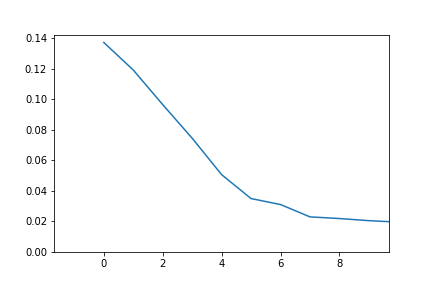

In [23]:
import matplotlib.pylab as plt
% matplotlib notebook
plt.plot([i for i in range(len(num))],num)

In [25]:
pca = PCA(n_components=2)
pca.fit(data)
new_data = pca.transform(data)
new_data.shape

(11548, 2)

<IPython.core.display.Javascript object>


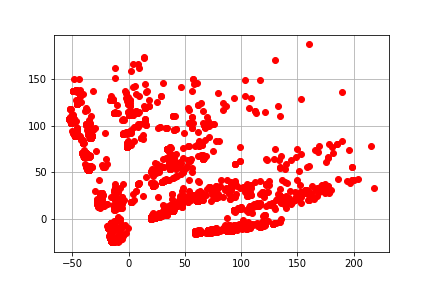

In [29]:
% matplotlib notebook
plt.plot([i for i in new_data[:, 0]],[i for i in new_data[:, 1]], 'ro')
plt.grid()